# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function is to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability, i.e., make the prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html



**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- We will check the correctness of your implementation using the tests below.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [2]:
import scipy

ALPHA = 1.0 # for additive smoothing

# Distribution for continuous features
class ContFeatureParam:
    
    def __init__(self):
        self.mu = None
        self.sigma = None
    
    def estimate(self, X):
        # Estimate the parameters for the Gaussian distribution so that it best describes the input data X
        self.mu = np.mean(X)
        self.sigma = np.std(X)
        
        # if sigma is too small, add a small constant to it to avoid division by zero
        if self.sigma == 0.0:
            self.sigma = 1e-6

    def get_log_probability(self, X_new):
        # return the log of the density values for the input values X_new
        return scipy.stats.norm.logpdf(X_new, self.mu, self.sigma)

# Distribution for binary features
class BinFeatureParam:
    
    def __init__(self):
        self._p = None
        
    def estimate(self, X):
        # Estimate the parameters for the Bernoulli distribution so that it best describes the input data X
        ones = np.sum(X)
        total = len(X)
        self.p = (ones + ALPHA) / (total + ALPHA * 2)

    def get_log_probability(self, X_new):
        # return the log of the probability values for the input values X_new
        return scipy.stats.bernoulli.logpmf(X_new, self.p)

# Distribution for categorical features
class CatFeatureParam:
    
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self.num_of_categories = num_of_categories
        self.p = []
    
    def estimate(self, X):
        # Estimate the parameters for the Multinoulli distribution so that it best describes the input data X
        X = np.append(X, range(0,self.num_of_categories))
        # count the appearances of the individual categories
        categories, counts = np.unique(X, return_counts=True)

        # and then calculate the probabilities for all categories
        self.p = list(dict(zip(categories, counts / sum(counts))).values())
        
    def get_log_probability(self, X_new):
        # return the log of the probability values for the input values X_new
        return (np.log([self.p[i] if i<=(len(self.p)-1) else 1e-6 for i in X_new]))


**Tests:**
    
We will use the code below to test the correctness of your code.

In [3]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [4]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [5]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.94591015 -2.1690537  -1.94591015 -2.45673577 -2.1690537  -2.86220088
 -1.94591015 -3.55534806 -2.1690537  -2.86220088]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [6]:
import math

# Your task is to implement the three functions of NBC. 

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[]):
        self.feature_types = feature_types

    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        
        # retrieve amount of classes together with a count of occurrences
        self.classes, counts = np.unique(y, return_counts=True)
        self.dict_classes = dict(zip(self.classes, counts))

        _, self.number_of_features = X.shape
               
        # keep dictionary of all computed priors and thetas
        self.dict_priors = {}
        self.dict_thetas = {}
        
        # iterate classes
        for c in self.classes:
            
            # for each class estimate the class prior
            prior = self.dict_classes[c] / len(y)
            #  add prior to list of priors
            self.dict_priors[c] = prior
            
            # add new array to dic_thetas
            self.dict_thetas[c] = []
            
            # iterate over all possible features
            for j in range(self.number_of_features):
                # get data of feature with class c as a result
                X_jc = X[y==c, j]                
                # estimate theta_jc (based on feature type)
                if self.feature_types[j] == 'r':
                    param = ContFeatureParam()
                if self.feature_types[j] == 'b':
                    param = BinFeatureParam()                
                if self.feature_types[j] == 'c':
                    # if feature is categorical, retrieve amount of categories first
                    categories, counts = np.unique(X[:,j], return_counts=True)
                    param = CatFeatureParam(len(categories))                
                # estimate theta_fc (based on the type of feature)
                param.estimate(X_jc)
                # add theta to list of thetas for specific class
                self.dict_thetas[c].append(param)
      
                
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        
        total_probs = []
        # iterate classes
        for c in self.classes:
            # get log of prior
            log_prob_c = math.log(self.dict_priors[c])
            # iterate over all possible features
            for j in range(self.number_of_features):
                # only data of relevant feature,
                X_j = X[:,j]
                # compute log_probability for this feature for all data points
                log_prob_cj = self.dict_thetas[c][j].get_log_probability(X_j) 
                # add them to the log_prob_c
                log_prob_c += log_prob_cj
            
            # add vector to total_probabilites
            total_probs.append(log_prob_c)
        
        # after iterating through all classes, make class-prediction for each datapoint
        yhat = np.argmax(total_probs, axis=0)
        return yhat

**Tests**

We will use the code below to check your code.

In [7]:
# All features of the iris dataset are continuous.

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]

nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)

Accuracy: 0.9333333333333333
[2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [8]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('./datasets/binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 0]


In [9]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('./datasets/categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['c'] * 9)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat) 

Accuracy: 0.6896551724137931
[0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]


## Logistic Regression

For logistic regression, you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [10]:
from sklearn.linear_model import LogisticRegression

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    tst_errs_nbc = []
    tst_errs_lr = []
    
    # calculate split size
    N = X.shape[0]
    Ntrain = int(0.8 * N)
    
    for i in range(num_splits):
        
        # temp lists for test errors
        errs_nbc = []
        errs_lr = []
        
        # calculate split size
        Nsplit = int(Ntrain * (i+1) / num_splits)
        
        for j in range(num_runs):
            
            # shuffle and split data
            shuffler = np.random.permutation(N)

            Xtrain = X[shuffler[:Nsplit]]
            ytrain = y[shuffler[:Nsplit]]
            Xtest = X[shuffler[Nsplit:]]
            ytest = y[shuffler[Nsplit:]]
            
            # make sure that more than one target is present in the training set
            if len(np.unique(ytrain)) != 1:
            
                # run NBC num_runs times
                nbc.fit(Xtrain, ytrain)
                yhat = nbc.predict(Xtest)
                errs_nbc.append(np.mean(yhat != ytest))
            
                # run LR num_runs times
                lr.fit(Xtrain, ytrain)
                yhat = lr.predict(Xtest)
                errs_lr.append(np.mean(yhat != ytest))
            
        # calculate average test errors across the runs
        tst_errs_nbc.append(np.mean(errs_nbc))
        tst_errs_lr.append(np.mean(errs_lr))
        
    return tst_errs_nbc, tst_errs_lr

In [12]:
def makePlot(nbc_perf, lr_perf, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. Prepare the data for the two classifiers, e.g., handle missing values and the categorical data. When you handle the categorical data, you should check whether the data is ordinal or not. If the data is ordinal, you should encode the data as integers. If the data is not ordinal, you should encode the data as one-hot vectors.
2. Show the first 5 rows of the prepared data
3. Compare the two classifiers on the dataset and generate the plots

The grading will be based on whether the data is correctly prepared and the plots are generated without errors. The grading will not be based on the performance of the classifiers and whether the plots are the same as in the paper. 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [13]:
from sklearn.datasets import load_iris
iris = load_iris()

In [14]:
# transform to dataframe
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

In [15]:
# check missing data
iris_df.isnull().sum()

# there is no missing data --> no need to do imputation

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64

In [16]:
# check categorical features
iris_df.info()

# the iris dataset only contains continuous features --> no need to deal with categorical data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [17]:
# display first 5 rows
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


/home/hannah/miniconda3/envs/dl-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hannah/miniconda3/envs/dl-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

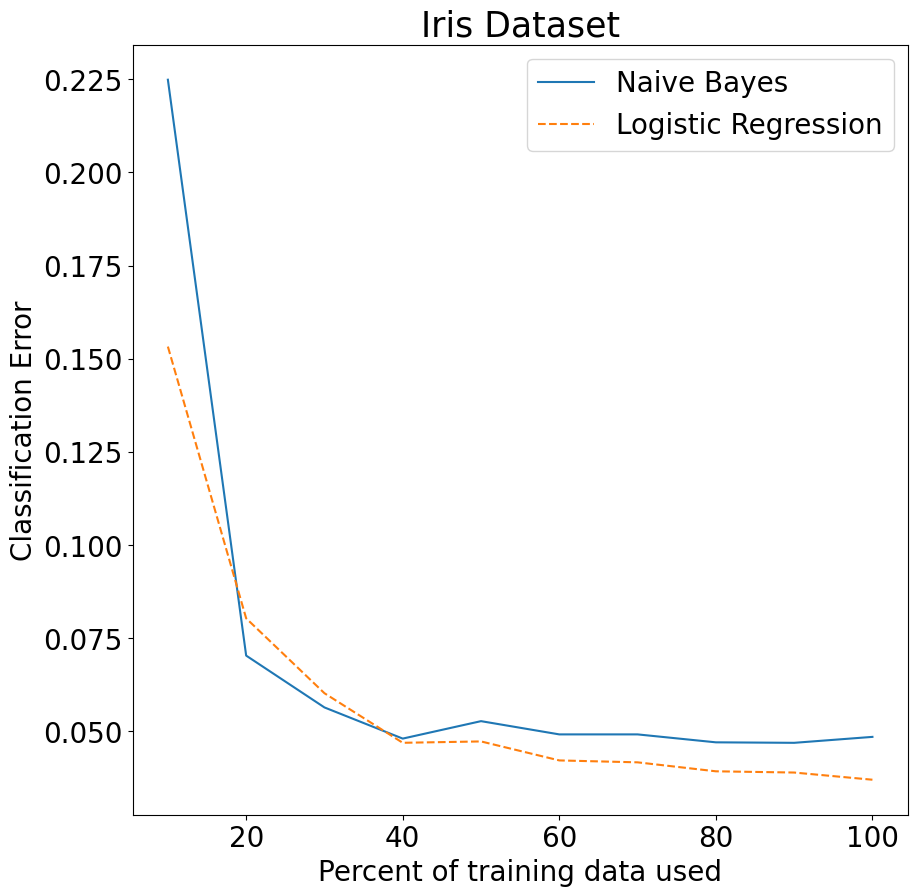

In [18]:
# Comparison
nbc = NBC(feature_types=['r', 'r', 'r', 'r'])
lr = LogisticRegression()

tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc, lr, iris.data, iris.target, num_runs=200, num_splits=10)
makePlot(tst_errs_nbc, tst_errs_lr, title='Iris Dataset')

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. 

In [19]:
voting = pd.read_csv('./datasets/voting.csv')

voting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   label                                   435 non-null    object
 1   handicapped-infants                     423 non-null    object
 2   water-project-cost-sharing              387 non-null    object
 3   adoption-of-the-budget-resolution       424 non-null    object
 4   physician-fee-freeze                    424 non-null    object
 5   el-salvador-aid                         420 non-null    object
 6   religious-groups-in-schools             424 non-null    object
 7   anti-satellite-test-ban                 421 non-null    object
 8   aid-to-nicaraguan-contras               420 non-null    object
 9   mx-missile                              413 non-null    object
 10  immigration                             428 non-null    object
 11  synfue

In [20]:
# check missing data
voting.isnull().sum()

# there is missing data
# imputing binary values can lead to wrong results
# since the feature export-administration-act-south-africa has more than 100 missing values which makes up alsmost 25% of all entries it does not make sense to drop them
# therefore we will impute the missing values with the mode of the feature
#for column in voting.columns:
#    if voting[column].dtypes == 'object':
#        voting[column].fillna(voting[column].mode()[0], inplace=True)

# drop missing values
voting.dropna(inplace=True)

In [21]:
# check how many data points are left
voting.shape # 232 data points left

(232, 17)

In [22]:
# check categorical features
#voting.head()

# the label feature is categorical --> use one-hot encoding
# create dummy variables
#voting = pd.get_dummies(voting, columns=['label'])

# we dont have to deal with categorical features in the label

In [23]:
# convert binary values to 0 and 1
voting.replace('y', 1, inplace=True)
voting.replace('n', 0, inplace=True)

In [24]:
# convert label to 0 and 1
# democrat = 1, republican = 0
voting.replace('democrat', 1, inplace=True)
voting.replace('republican', 0, inplace=True)

In [25]:
# display first 5 rows
voting.head()

,label,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
5,1,0,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1
8,0,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
19,1,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1
23,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,1,1
25,1,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,1


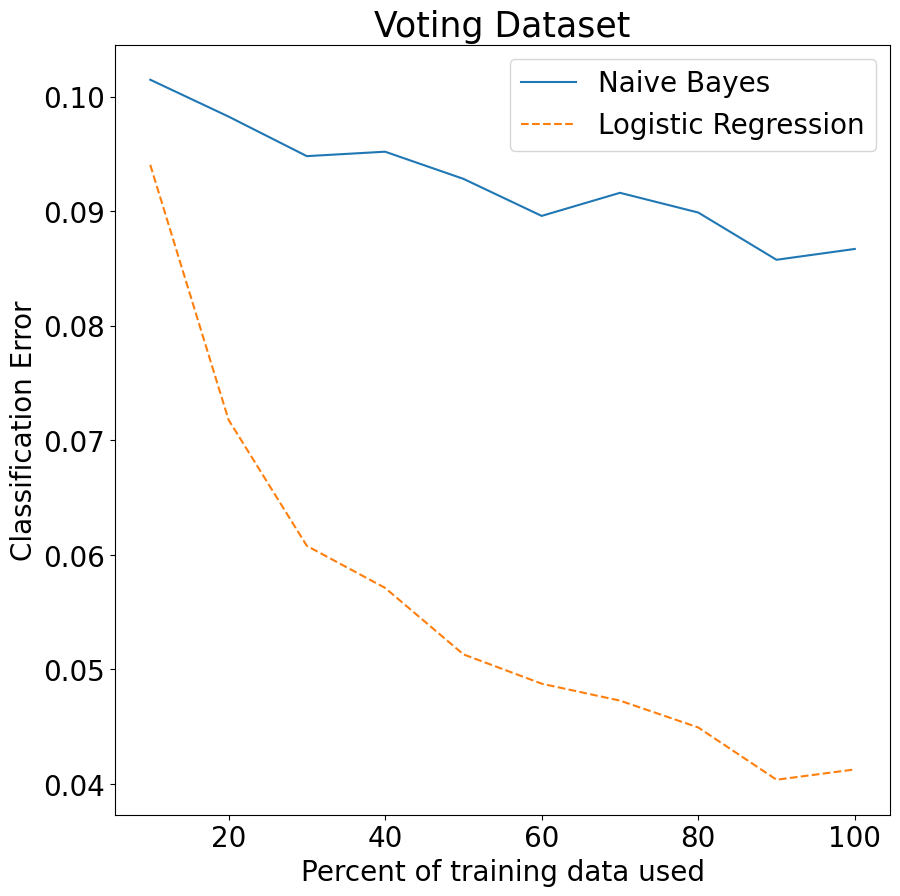

In [26]:
# split dataframe into label and data
voting_target = voting["label"].values
voting_data = voting.drop('label', axis=1).values

# Comparison
nbc = NBC(feature_types=['b'] * voting_data.shape[1])
lr = LogisticRegression()

tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc, lr, voting_data, voting_target, num_runs=200, num_splits=10)
makePlot(tst_errs_nbc, tst_errs_lr, title='Voting Dataset')

**Dataset 3: Breast Cancer Dataset (Bonus Tasks)**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

The dataset has continues, binary and categorical features. It also has missing values.

Hints: You can precompute the size of the domains of the categorical features.

In [27]:
# load the dataset
cancer = pd.read_csv('./datasets/breast-cancer.csv')

cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [28]:
# check missing data
cancer.isnull().sum()

# no missing data --> no need to do imputation

Class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
dtype: int64

In [29]:
# check features
print("Class: ", cancer['Class'].unique())
print("age: ", cancer['age'].unique())
print("menopause: ", cancer['menopause'].unique())
print("tumor-size: ", cancer['tumor-size'].unique())
print("inv-nodes: ", cancer['inv-nodes'].unique())
print("node-caps: ", cancer['node-caps'].unique())
print("deg-malig: ", cancer['deg-malig'].unique())
print("breast: ", cancer['breast'].unique())
print("breast-quad: ", cancer['breast-quad'].unique())
print("irradiat: ", cancer['irradiat'].unique())


Class:  ['no-recurrence-events' 'recurrence-events']
age:  ['30-39' '40-49' '60-69' '50-59' '70-79' '20-29']
menopause:  ['premeno' 'ge40' 'lt40']
tumor-size:  ['30-34' '20-24' '15-19' '0-4' '25-29' '50-54' '10-14' '40-44' '35-39'
 '5-9' '45-49']
inv-nodes:  ['0-2' '6-8' '9-11' '3-5' '15-17' '12-14' '24-26']
node-caps:  ['no' 'yes' '?']
deg-malig:  [3 2 1]
breast:  ['left' 'right']
breast-quad:  ['left_low' 'right_up' 'left_up' 'right_low' 'central' '?']
irradiat:  ['no' 'yes']


In [30]:
# convert '?' to NaN
cancer.replace('?', np.nan, inplace=True)

# check missing values again
cancer.isnull().sum()

# remove missing values
cancer.dropna(inplace=True)

In [31]:
# Class is binary --> convert to 0 and 1
cancer.replace('no-recurrence-events', 0, inplace=True)
cancer.replace('recurrence-events', 1, inplace=True)

# node-caps and irradiat are binary --> convert to 0 and 1
cancer.replace('yes', 1, inplace=True)
cancer.replace('no', 0, inplace=True)

# breast is binary --> convert to 0 and 1
cancer.replace('left', 1, inplace=True)
cancer.replace('right', 0, inplace=True)

# age is categorical --> use one-hot encoding
cancer = pd.get_dummies(cancer, columns=['age'])

# menopause is categorical --> use one-hot encoding
cancer = pd.get_dummies(cancer, columns=['menopause'])

# tumor-size is categorical --> use one-hot encoding
cancer = pd.get_dummies(cancer, columns=['tumor-size'])

# inv-nodes is categorical --> use one-hot encoding
cancer = pd.get_dummies(cancer, columns=['inv-nodes'])

#breast-quad is categorical --> use one-hot encoding
cancer = pd.get_dummies(cancer, columns=['breast-quad'])

# deg-malig is continuous --> no need to do anything

In [32]:
# display first 5 rows
cancer.head()

,Class,node-caps,deg-malig,breast,irradiat,age_20-29,age_30-39,age_40-49,age_50-59,age_60-69,...,inv-nodes_15-17,inv-nodes_24-26,inv-nodes_3-5,inv-nodes_6-8,inv-nodes_9-11,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
0,0,0,3,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,2,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


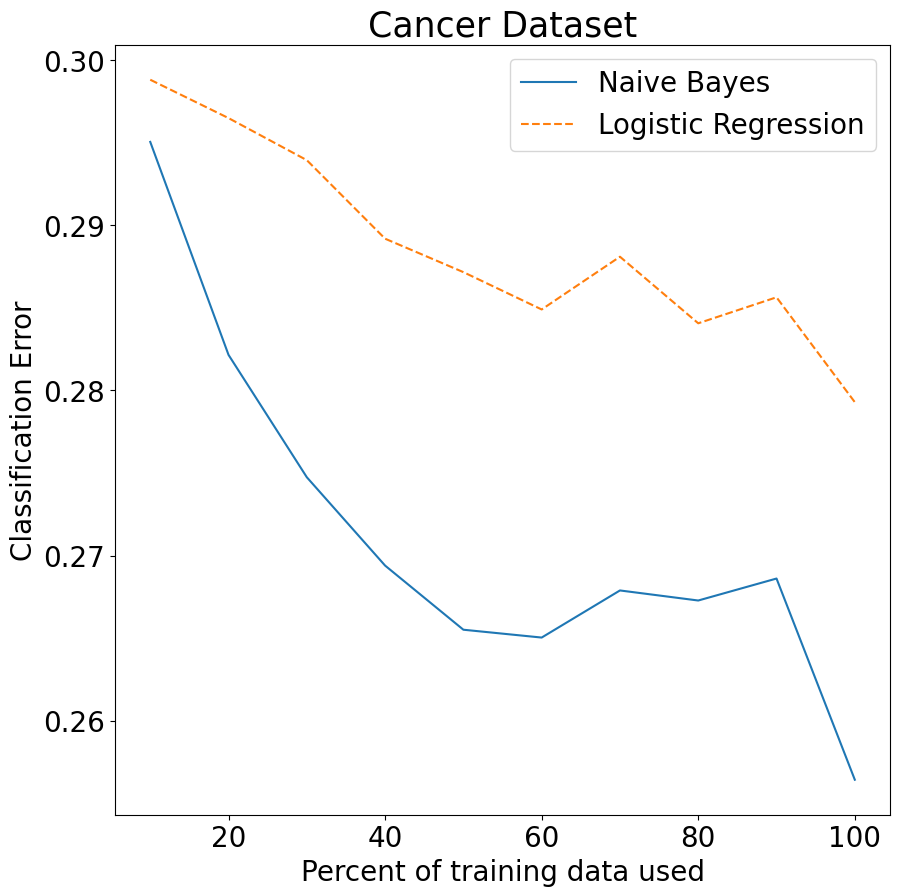

In [35]:
# split dataframe into label and data
cancer_target = cancer["Class"].values
cancer_data = cancer.drop('Class', axis=1).values

# Comparison
nbc = NBC(feature_types=['c'] * 9 + ['c'] * 3 + ['c'] * 12 + ['c'] * 13 + ['b'] + ['c'] + ['b'] + ['c'] * 5 + ['b'])
lr = LogisticRegression()

tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc, lr, cancer_data, cancer_target, num_runs=200, num_splits=10)
makePlot(tst_errs_nbc, tst_errs_lr, title='Cancer Dataset')